<a href="https://colab.research.google.com/github/zack-murray/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [2]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

     |████████████████████████████████| 102kB 2.3MB/s 
     |████████████████████████████████| 245kB 2.8MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 8.7MB 8.5MB/s 
     |████████████████████████████████| 614kB 43.4MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 1.5MB 28.8MB/s 
     |████████████████████████████████| 296kB 47.8MB/s 
     |████████████████████████████████| 256kB 46.1MB/s 
     |████████████████████████████████| 307kB 47.6MB/s 
     |████████████████████████████████| 215kB 46.6MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 747kB 47.9MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=bcbc757b81aaca5983d48dd0e028a371f26512f35117dedf8b382b4bc34e511a
  Stored in directo

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [4]:
# Check Pandas Profiling version
import pandas_profiling
pandas_profiling.__version__

'2.6.0'

In [4]:
!pip install pandas==0.25

     |████████████████████████████████| 10.5MB 2.8MB/s 
ERROR: visions 0.2.2 has requirement pandas>=0.25.3, but you'll have pandas 0.25.0 which is incompatible.
ERROR: pandas-profiling 2.5.0 has requirement pandas==0.25.3, but you'll have pandas 0.25.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 0.25.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
  Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3


In [6]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile



---

###Do train/validate/test split with the Tanzania Waterpumps data.

---



In [15]:
# Split training set into train & val
train, val = train_test_split(train, train_size=.75, stratify=train['status_group'], 
                              random_state=22)

train.shape, val.shape, test.shape

((44550, 41), (14850, 41), (14358, 40))



---

###Begin with baselines for classification.

---



In [16]:
train['status_group'].value_counts(normalize=True)

functional                 0.543075
non functional             0.384242
functional needs repair    0.072682
Name: status_group, dtype: float64

In [17]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
14927,68924,30.0,2011-03-03,Government Of Tanzania,194,DWE,38.836755,-5.163121,Kwamgaya,0,Pangani,Nkumbi,Tanga,4,3,Muheza,Lusanga,1,True,GeoData Consultants Ltd,VWC,Kwemkuna,False,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
27038,13662,0.0,2012-10-25,Hsw,1259,HSW,33.851224,-1.757185,Shuleni,0,Lake Victoria,Madaraka,Mara,20,3,Musoma Rural,Kukirango,750,NaN,GeoData Consultants Ltd,Parastatal,NaN,True,1996,gravity,gravity,gravity,parastatal,parastatal,unknown,unknown,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,non functional
45293,18718,0.0,2013-02-19,Danida,940,DANIDA,35.862650,-10.616147,Kwa Sumoyo,0,Rufiji,Madukani,Ruvuma,10,5,Namtumbo,Luegu,360,True,GeoData Consultants Ltd,WUG,NaN,False,1994,swn 80,swn 80,handpump,wug,user-group,pay when scheme fails,on failure,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
23577,31656,100.0,2013-02-22,Robert Loyal,1108,World vision,37.152834,-3.569853,Enguselo,0,Pangani,Enguselo,Manyara,21,4,Simanjiro,Mererani,200,True,GeoData Consultants Ltd,VWC,Kambi ya chokaa pipe scheme,True,2006,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
52391,64616,0.0,2011-04-07,NaN,0,NaN,33.876240,-9.299168,Mbusanya,0,Lake Nyasa,Mbusanya,Mbeya,12,4,Rungwe,Itete,0,True,GeoData Consultants Ltd,VWC,K,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional


In [0]:
import numpy as np
# Define a function to wrangle train, validate, and test sets in the same way

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    # drop more columns with striking similarities
    X = X = X.drop(columns=['extraction_type_group', 'extraction_type_class', 
                   'payment_type', 'quality_group', 'source_type', 'source_class',
                   'region_code', 'district_code', 'waterpoint_type_group'])
    # drop ambiguous columns that look to add little value
    X = X.drop(columns=['num_private', 'lga', 'ward'])
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)



---

###Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.

---



In [20]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

train_features.select_dtypes(exclude='number').nunique()
# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists to define our features
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'management', 'management_group', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type']


In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [22]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

# Fit on train
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'recorded_by', 'scheme_management',
                                     'permit', 'extraction_type', 'management',
                                     'management_group', 'payment',
                                     'water_quality', 'quantity', 'source',
                                     'waterpoint_type'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_nam...
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True



---

###Get your validation accuracy score.

---



In [23]:
# Score on validation
print ('Validation Accruacy', pipeline.score(X_val, y_val))

Validation Accruacy 0.7352861952861953




---

### Get and plot your feature importances.

---



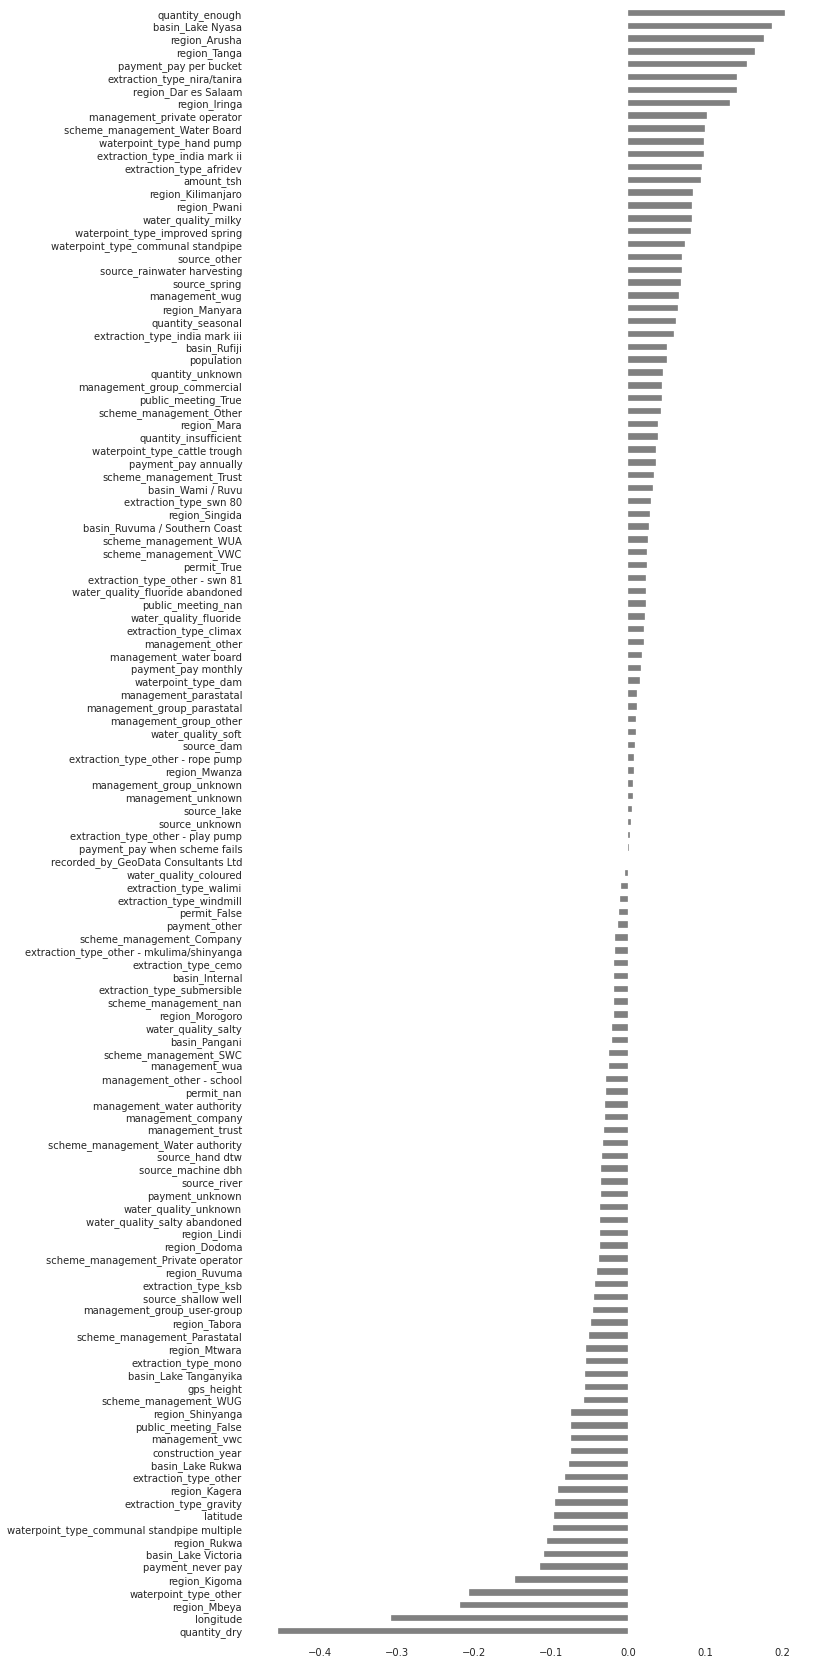

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
# Instantiate logistic regression model and one-hot encoder
model = pipeline.named_steps['logisticregression']
encoder = pipeline.named_steps['onehotencoder']
# Apply models and visualize feature importance
encoded_columns = encoder.transform(X_val).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');



---

###Trying out decision tree


---



In [25]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on validation
print ('Train Accuracy', pipeline.score(X_train, y_train))
print ('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

Train Accuracy 0.8050953984287318
Validation Accuracy 0.7705050505050505
